In [39]:
from netCDF4 import *
import matplotlib.pyplot as plt
import matplotlib.colors as co
import matplotlib.ticker as ticker
from path import Path
import pandas as pd
import xarray as xr
import numpy as np
import math
import scipy.interpolate as interp
import scipy.stats as stats
import tkinter as tk
import os

from matplotlib import rc
font = {"family": "serif", "weight": "normal", "size": 13}
rc("font", **font)
rc("text", usetex=True)



In [40]:
def get_imax(field_name = "fields",step = 1):
    i = 0
    while os.path.exists(r"C:\\Users\\albou\Desktop\\The_Ocean_Cleanup\Work\\Github\Simulation\Submesoscale simulation\\Forcing\\"+field_name+"\\field"+str(i)):
        i += step
    return i-1

In [41]:
def get_u_field(i,field_name = "fields"):
    if os.path.exists(r"C:\\Users\\albou\Desktop\\The_Ocean_Cleanup\Work\\Github\Simulation\Submesoscale simulation\\Forcing\\"+field_name+"\\field"+str(i)) :
            #import field
            
            path = Path(r"C:\\Users\\albou\Desktop\\The_Ocean_Cleanup\Work\\Github\Simulation\Submesoscale simulation\\Forcing\\"+field_name+"\\field"+str(i)+"\\ux")
            with open(path, "r") as f:
                lines = [line.strip() for line in f if line.strip()]
            data_lines = lines[1:]
            data = [list(map(float, line.split())) for line in data_lines]

            size = int(math.sqrt(len(data)))

            field_ux = np.zeros((size, size))

            for x in range(size):
                for y in range(size):
                    field_ux[x, y] = data[x * size + y][2]

            path = Path(r"C:\\Users\\albou\Desktop\\The_Ocean_Cleanup\Work\\Github\Simulation\Submesoscale simulation\\Forcing\\"+field_name+"\\field"+str(i)+"\\uy")
            with open(path, "r") as f:
                lines = [line.strip() for line in f if line.strip()]
            data_lines = lines[1:]
            data = [list(map(float, line.split())) for line in data_lines]

            size = int(math.sqrt(len(data)))

            field_uy = np.zeros((size, size))

            for x in range(size):
                for y in range(size):
                    field_uy[x, y] = data[x * size + y][2]

            return field_ux, field_uy
    else:
         raise FileNotFoundError("The specified field does not exist.")

In [42]:
def get_vort_field(i,field_name = "fields"):
    if os.path.exists(r"C:\\Users\\albou\Desktop\\The_Ocean_Cleanup\Work\\Github\Simulation\Submesoscale simulation\\Forcing\\"+field_name+"\\field"+str(i)) :
            #import field
            
            path = Path(r"C:\\Users\\albou\Desktop\\The_Ocean_Cleanup\Work\\Github\Simulation\Submesoscale simulation\\Forcing\\"+field_name+"\\field"+str(i)+"\\omega")
            with open(path, "r") as f:
                lines = [line.strip() for line in f if line.strip()]
            data_lines = lines[1:]
            data = [list(map(float, line.split())) for line in data_lines]

            size = int(math.sqrt(len(data)))

            field_vort = np.zeros((size, size))

            for x in range(size):
                for y in range(size):
                    field_vort[x, y] = data[x * size + y][2]


            return field_vort
    else:
         raise FileNotFoundError("The specified field does not exist.")

In [43]:
def get_energy(field_name = "fields", step = 1):
    imax = get_imax(field_name,step)
    
    energy_series = []
    for i in range(0,imax+1,step):
        field_ux, field_uy = get_u_field(i,field_name)
        mean_ux = np.mean(field_ux)
        mean_uy = np.mean(field_uy) 
        energy = 0.5 * np.sum((field_ux-mean_ux)**2 + (field_uy-mean_uy)**2)/(550000**2)
        energy_series.append(energy)
    
    return energy_series            

In [44]:
def get_enstrophy(field_name = "fields",step = 1):
    imax = get_imax(field_name,step)
    
    enstrophy_series = []

    for i in range(0,imax+1,step):
        field_vort = get_vort_field(i,field_name)
        mean_vort = np.mean(field_vort) 
        enstrophy = 0.5 * np.sum((field_vort-mean_vort)**2)/((550000)**2)
        enstrophy_series.append(enstrophy)
    
    return enstrophy_series      

In [45]:
def get_vorticity(field_name = "fields",step = 1):
    imax = get_imax(field_name,step)

    vorticity_series = []

    for i in range(0,imax+1,step):
        field_vort = get_vort_field(i,field_name)
        vorticity = np.sum(field_vort)
        vorticity_series.append(vorticity)
    
    return vorticity_series    

In [46]:
def get_spectrum(filename,step = 1):
    path = Path(r"C:\\Users\\albou\Desktop\\The_Ocean_Cleanup\\Work\\Github\\Simulation\\Submesoscale simulation\\Forcing\\comparison_spectrum\\" + filename + ".csv")
    df = pd.read_csv(path)
    cl = df["characteristic_length"].values
    spectrums_sequence = []
    size = (len(df.keys())-1)*step 
    for i in range(0,size,step) :
        spectrums_sequence.append(df[str(i)])
    return cl, np.stack(spectrums_sequence)

In [47]:
def get_spectrum_number(filename):
    _, spectrums_sequence = get_spectrum(filename)
    return np.shape(spectrums_sequence)[0]

In [48]:
def get_spectrum_energy(filename,step = 1):
    cl, spectrums_sequence = get_spectrum(filename,step)
    energy_series = []
    for i in range(0,len(spectrums_sequence)):
        spectrum = spectrums_sequence[i]
        energy = spectrum[0]/(cl[0])
        for i in range(1,len(spectrum)):
            energy += spectrum[i]*(1/cl[i]-1/cl[i-1])
        energy_series.append(energy)
    return energy_series

In [49]:
def get_spectrum_enstrophy(filename,step = 1):
    cl, spectrums_sequence = get_spectrum(filename,step)
    enstrophy_series = []
    for i in range(0,len(spectrums_sequence)):
        spectrum = spectrums_sequence[i]
        enstrophy = spectrum[0]/cl[0]**3
        for i in range(1,len(spectrum)):
            enstrophy += spectrum[i]*1/(cl[i]**2)*(1/cl[i]-1/cl[i-1])
        enstrophy_series.append(enstrophy)
    return enstrophy_series

In [50]:
file  = "Noise/noise"
EDSfile = "EDS_noise"
step = 1

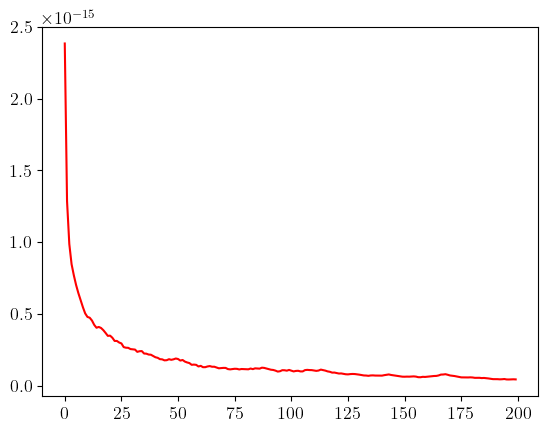

In [51]:
# enstrophy_series = get_enstrophy(file,step)
enstrophy_series_spectrum = get_spectrum_enstrophy(EDSfile,step)

# plt.plot(enstrophy_series, color="blue")
plt.plot(enstrophy_series_spectrum, color="red")

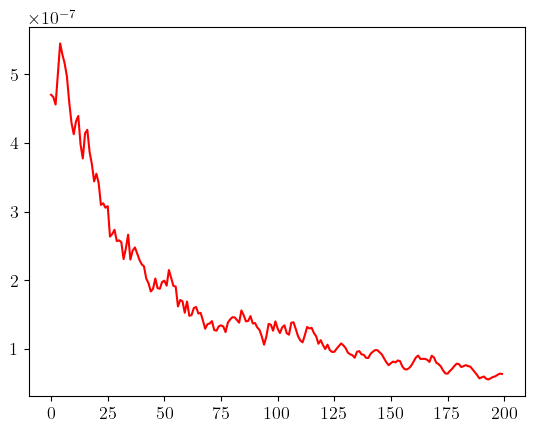

In [52]:
# energy_series = get_energy(file,step)
energy_series_spectrum = get_spectrum_energy(EDSfile,step)

ax = plt.gca()


# plt.plot(energy_series, color="blue")
plt.plot(energy_series_spectrum, color="red")

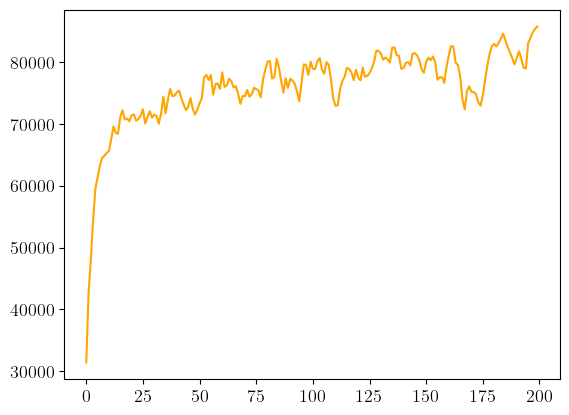

In [53]:
# plt.plot((5*np.array(energy_series)/np.array(enstrophy_series))**0.5,color = "blue")
plt.plot((5*np.array(energy_series_spectrum)/np.array(enstrophy_series_spectrum))**0.5,color = "orange")